In [1]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper


In [2]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=500)
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [3]:
arxiv.invoke("What is attention is all you need?")

'Published: 2022-09-18\nTitle: The Mosquito incident and the need-(not-)to-know\nAuthors: Karl Svozil\nSummary: I am reporting here how professor Cristian Sorin Calude, henceforth called\nCris, became involved in the "Mosquito incident". More generally, the\nrelationship between the single individual vis-a-vis the state or collective is\nreviewed, with special emphasis to need-(not)-to-know secrets.\n\nPublished: 2012-12-08\nTitle: Specker\'s fundamental principle of quantum mechanics\nAuthors: Adan Cabello'

In [4]:
wiki_wrapper_arxiv = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=500)
wiki=WikipediaQueryRun(api_wrapper=wiki_wrapper_arxiv)
print(wiki.name)

wikipedia


In [5]:
wiki.invoke("What is Machine learning?")

'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.\nML fi'

In [6]:
from dotenv import load_dotenv

load_dotenv()

import os

os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY')
os.environ['TAVILY_API_KEY'] = os.getenv('TAVILY_API_KEY')
os.environ['LANGCHAIN_API_KEY'] = os.getenv("LANGCHAIN_API_KEY")
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_PROJECT'] = "ReAct-agent"


In [7]:
# Tavily search tool

from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults()

/var/folders/m1/w29m4r7d2jqd3x6kl1chyshm0000gp/T/ipykernel_8464/358467908.py:5: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults()


## creating custom tools

In [8]:
# Creating custom function

def multiple(a: int, b: int) -> int:
    """Multiply a and b
    Args:
        a: fitst int
        b: second int
    """
    return a * b

def add(a: int, b: int) -> int:
    """
    Add a and b
    args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """
    Divide a by b
    args:
        a: fitst int
        b: second int
    """
    return a / b


## Creating tools


In [9]:
tools = [arxiv, wiki, tavily, add, multiple, divide]

## LLM invoketion

In [10]:
from langchain_groq import ChatGroq

LLM = ChatGroq(model='llama-3.1-8b-instant')

In [11]:
from pydantic import BaseModel
from langchain_core.messages import AIMessage, HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import AnyMessage, add_messages
from typing import Annotated

class State(BaseModel):
    messages: Annotated[list[AnyMessage], add_messages]

In [12]:
llm_with_tools = LLM.bind_tools(tools)

#### LLM tool creation

In [13]:
def llm_tool(state: State):
    return {'messages': llm_with_tools.invoke(state.messages)}

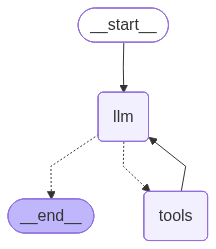

In [14]:
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import display, Image

builder = StateGraph(State)

builder.add_node('llm', llm_tool)
builder.add_node('tools', ToolNode(tools))

builder.add_edge(START, "llm")
builder.add_conditional_edges("llm", tools_condition)
builder.add_edge('tools', "llm") # This is something that makes agent into ReAct type

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
from pprint import pprint
message = graph.invoke({'messages': "provide me the top 10 AI news, then give me the addition of 5 and 6 and multiply it with 10."
})


for msg in message['messages']:
    msg.pretty_print()

================================ Human Message =================================

provide me the top 10 AI news, then give me the addition of 5 and 6 and multiply it with 10.
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (9ms78pef5)
 Call ID: 9ms78pef5
  Args:
    query: AI news top 10
  add (trxe1f3bw)
 Call ID: trxe1f3bw
  Args:
    a: 5
    b: 6
  multiple (k6zszyxnx)
 Call ID: k6zszyxnx
  Args:
    a: 30
    b: 10
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "AI 2024 in review: The 10 most notable AI stories of the year", "url": "https://iot-analytics.com/ai-2024-10-most-notable-stories/", "content": "### 10. Largest AI-related funding rounds: Databricks, OpenAI, and xAI\n\nDatabricks investments soar on the wings of AI. On December 17, 2024, US-based AI cloud data platform Databricks announced it had raised $10 billion in Seri